<a href="https://colab.research.google.com/github/HanByeonghyun/HanByeonghyun/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%88%99%EC%A0%9C4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


아래의 load_images () 함수는 이를 구현합니다. 주어진 디렉터리에 있는 이미지 목록을 열거하고, 각각을 256*512 픽셀의 대상 크기로 로드하고, 각 이미지를 위성 및 지도 요소로 분할하고 각각의 배열을 반환합니다.

훈련 데이터 세트에 대한 경로를 사용하여 이 함수를 호출할 수 있습니다. 일단 로드되면 준비된 배열을 나중에 사용하기 위해 압축 형식으로 새 파일에 저장할 수 있습니다.

실행하면 훈련 데이터 세트의 모든 이미지가 로드되고 이미지의 모양이 요약되어 이미지가 올바르게 로드되었는지 확인한 다음 배열이 압축된 NumPy 배열 형식으로 maps_256.npz 라는 새 파일에 저장됩니다.

이 파일은 나중에 load() NumPy 함수를 통해 로드 하고 각 배열을 차례로 검색할 수 있습니다.

그런 다음 일부 이미지 쌍을 플롯하여 데이터가 올바르게 처리되었는지 확인할 수 있습니다

In [ ]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (642, 256, 256, 3) (642, 256, 256, 3)
Saved dataset:  maps_256.npz


실행하면 준비된 데이터 세트가 로드되고 각 배열의 모양이 요약되어 1,000개가 조금 넘는 256*256 이미지 쌍에 대한 기대가 확인됩니다.

상단에는 위성 이미지, 하단에는 Google 지도 이미지를 표시하는 세 개의 이미지 쌍의 플롯도 생성됩니다.

위성 이미지는 매우 복잡하고 Google 지도 이미지는 훨씬 단순하지만 주요 도로, 물, 공원과 같은 항목에 대한 색상 코딩이 있음을 알 수 있습니다.

Loaded:  (642, 256, 256, 3) (642, 256, 256, 3)


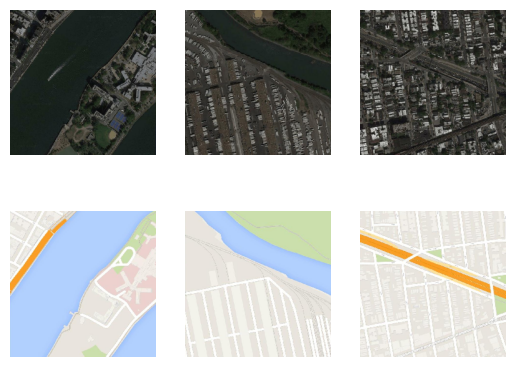

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (642, 256, 256, 3) (642, 256, 256, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
>3921, d1[0.093] d2[0.160] g[12.737]
1/1 [==============================] - 0s 21ms/step
>3922, d1[0.455] d2[0.494] g[7.426]
1/1 [==============================] - 0s 21ms/step
>3923, d1[0.093] d2[0.439] g[11.153]
1/1 [==============================] - 0s 22ms/step
>3924, d1[0.579] d2[0.153] g[6.772]
1/1 [==============================] - 0s 20ms/step
>3925, d1[0.360] d2[0.251] g[7.274]
1/1 [==============================] - 0s 21ms/step
>3926, d1[0.507] d2[0.394] g[7.824]
1/1 [==============================] - 0s 20ms/step
>3927, d1[0.143] d2[0.329] g[12.651]
1/1 [==============================] - 0s 21ms/step
>3928, d1[0.077] d2[0.218] g[12.112]
1/1 [==============================] - 0s 21ms/step
>3929, d1[0.267] d2[0.193] g[6.863]
1/1 [==============================] - 0s 24ms/step
>3930, d1[0.111] d2[0.251] g[6.797]
1/1 [==============================] - 0s 24ms/step
>3931, d1[0.121] d2[0.169] g[6.683]
1/1 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
>10341, d1[0.330] d2[0.389] g[6.134]
1/1 [==============================] - 0s 22ms/step
>10342, d1[0.250] d2[0.421] g[9.097]
1/1 [==============================] - 0s 20ms/step
>10343, d1[0.442] d2[0.270] g[5.258]
1/1 [==============================] - 0s 21ms/step
>10344, d1[0.384] d2[0.518] g[4.767]
1/1 [==============================] - 0s 21ms/step
>10345, d1[0.295] d2[0.360] g[7.295]
1/1 [==============================] - 0s 20ms/step
>10346, d1[0.494] d2[0.337] g[3.725]
1/1 [==============================] - 0s 20ms/step
>10347, d1[0.485] d2[0.310] g[2.686]
1/1 [==============================] - 0s 22ms/step
>10348, d1[0.228] d2[0.438] g[5.077]
1/1 [==============================] - 0s 20ms/step
>10349, d1[0.247] d2[0.347] g[5.480]
1/1 [==============================] - 0s 20ms/step
>10350, d1[0.481] d2[0.371] g[6.348]
1/1 [==============================] - 0s 21ms/step
>10351, d1[0.400] d2[0.361] g[4.603]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>16761, d1[0.356] d2[0.357] g[4.950]
1/1 [==============================] - 0s 22ms/step
>16762, d1[0.223] d2[0.373] g[5.865]
1/1 [==============================] - 0s 20ms/step
>16763, d1[0.330] d2[0.321] g[6.054]
1/1 [==============================] - 0s 20ms/step
>16764, d1[0.491] d2[0.294] g[4.141]
1/1 [==============================] - 0s 21ms/step
>16765, d1[0.378] d2[0.369] g[5.178]
1/1 [==============================] - 0s 21ms/step
>16766, d1[0.334] d2[0.374] g[4.737]
1/1 [==============================] - 0s 21ms/step
>16767, d1[0.253] d2[0.375] g[5.759]
1/1 [==============================] - 0s 21ms/step
>16768, d1[0.461] d2[0.298] g[5.363]
1/1 [==============================] - 0s 21ms/step
>16769, d1[0.358] d2[0.346] g[5.473]
1/1 [==============================] - 0s 20ms/step
>16770, d1[0.428] d2[0.490] g[2.848]
1/1 [==============================] - 0s 20ms/step
>16771, d1[0.392] d2[0.376] g[5.567]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>23181, d1[0.335] d2[0.303] g[4.782]
1/1 [==============================] - 0s 20ms/step
>23182, d1[0.259] d2[0.487] g[4.934]
1/1 [==============================] - 0s 20ms/step
>23183, d1[0.438] d2[0.281] g[4.504]
1/1 [==============================] - 0s 19ms/step
>23184, d1[0.293] d2[0.276] g[5.680]
1/1 [==============================] - 0s 19ms/step
>23185, d1[0.206] d2[0.313] g[6.061]
1/1 [==============================] - 0s 20ms/step
>23186, d1[0.327] d2[0.311] g[5.599]
1/1 [==============================] - 0s 19ms/step
>23187, d1[0.309] d2[0.265] g[5.253]
1/1 [==============================] - 0s 19ms/step
>23188, d1[0.287] d2[0.266] g[5.653]
1/1 [==============================] - 0s 19ms/step
>23189, d1[0.208] d2[0.360] g[5.341]
1/1 [==============================] - 0s 19ms/step
>23190, d1[0.387] d2[0.477] g[4.590]
1/1 [==============================] - 0s 19ms/step
>23191, d1[0.312] d2[0.308] g[5.656]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>29601, d1[0.323] d2[0.437] g[4.855]
1/1 [==============================] - 0s 20ms/step
>29602, d1[0.416] d2[0.366] g[4.329]
1/1 [==============================] - 0s 20ms/step
>29603, d1[0.360] d2[0.392] g[5.790]
1/1 [==============================] - 0s 19ms/step
>29604, d1[0.456] d2[0.339] g[1.737]
1/1 [==============================] - 0s 20ms/step
>29605, d1[0.401] d2[0.496] g[4.359]
1/1 [==============================] - 0s 19ms/step
>29606, d1[0.442] d2[0.418] g[3.524]
1/1 [==============================] - 0s 19ms/step
>29607, d1[0.285] d2[0.456] g[4.666]
1/1 [==============================] - 0s 20ms/step
>29608, d1[0.394] d2[0.283] g[4.395]
1/1 [==============================] - 0s 20ms/step
>29609, d1[0.420] d2[0.429] g[3.030]
1/1 [==============================] - 0s 19ms/step
>29610, d1[0.380] d2[0.418] g[3.720]
1/1 [==============================] - 0s 19ms/step
>29611, d1[0.349] d2[0.361] g[4.693]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>36021, d1[0.356] d2[0.351] g[3.440]
1/1 [==============================] - 0s 19ms/step
>36022, d1[0.365] d2[0.352] g[3.740]
1/1 [==============================] - 0s 18ms/step
>36023, d1[0.289] d2[0.397] g[5.984]
1/1 [==============================] - 0s 20ms/step
>36024, d1[0.348] d2[0.355] g[5.101]
1/1 [==============================] - 0s 21ms/step
>36025, d1[0.307] d2[0.405] g[4.095]
1/1 [==============================] - 0s 18ms/step
>36026, d1[0.367] d2[0.346] g[3.874]
1/1 [==============================] - 0s 19ms/step
>36027, d1[0.312] d2[0.388] g[4.025]
1/1 [==============================] - 0s 19ms/step
>36028, d1[0.401] d2[0.336] g[3.634]
1/1 [==============================] - 0s 19ms/step
>36029, d1[0.345] d2[0.320] g[4.796]
1/1 [==============================] - 0s 20ms/step
>36030, d1[0.361] d2[0.377] g[3.857]
1/1 [==============================] - 0s 20ms/step
>36031, d1[0.358] d2[0.399] g[3.478]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>42441, d1[0.288] d2[0.328] g[4.090]
1/1 [==============================] - 0s 20ms/step
>42442, d1[0.419] d2[0.307] g[2.306]
1/1 [==============================] - 0s 20ms/step
>42443, d1[0.308] d2[0.358] g[3.697]
1/1 [==============================] - 0s 21ms/step
>42444, d1[0.259] d2[0.349] g[4.856]
1/1 [==============================] - 0s 19ms/step
>42445, d1[0.425] d2[0.320] g[1.517]
1/1 [==============================] - 0s 19ms/step
>42446, d1[0.419] d2[0.320] g[2.803]
1/1 [==============================] - 0s 20ms/step
>42447, d1[0.340] d2[0.346] g[3.907]
1/1 [==============================] - 0s 20ms/step
>42448, d1[0.383] d2[0.353] g[2.055]
1/1 [==============================] - 0s 21ms/step
>42449, d1[0.229] d2[0.378] g[4.295]
1/1 [==============================] - 0s 19ms/step
>42450, d1[0.269] d2[0.381] g[4.447]
1/1 [==============================] - 0s 18ms/step
>42451, d1[0.384] d2[0.327] g[4.349]
1/1 [=================

Streaming output truncated to the last 5000 lines.
>48861, d1[0.363] d2[0.371] g[3.779]
1/1 [==============================] - 0s 19ms/step
>48862, d1[0.350] d2[0.398] g[2.057]
1/1 [==============================] - 0s 20ms/step
>48863, d1[0.376] d2[0.346] g[3.453]
1/1 [==============================] - 0s 20ms/step
>48864, d1[0.365] d2[0.371] g[4.320]
1/1 [==============================] - 0s 21ms/step
>48865, d1[0.347] d2[0.403] g[2.062]
1/1 [==============================] - 0s 22ms/step
>48866, d1[0.363] d2[0.385] g[2.178]
1/1 [==============================] - 0s 20ms/step
>48867, d1[0.366] d2[0.352] g[3.562]
1/1 [==============================] - 0s 20ms/step
>48868, d1[0.466] d2[0.312] g[3.567]
1/1 [==============================] - 0s 20ms/step
>48869, d1[0.330] d2[0.427] g[2.051]
1/1 [==============================] - 0s 20ms/step
>48870, d1[0.362] d2[0.397] g[1.220]
1/1 [==============================] - 0s 20ms/step
>48871, d1[0.357] d2[0.384] g[3.467]
1/1 [=================

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 20ms/step
>55282, d1[0.375] d2[0.381] g[3.598]
1/1 [==============================] - 0s 20ms/step
>55283, d1[0.374] d2[0.382] g[3.240]
1/1 [==============================] - 0s 20ms/step
>55284, d1[0.375] d2[0.380] g[3.265]
1/1 [==============================] - 0s 22ms/step
>55285, d1[0.374] d2[0.381] g[3.292]
1/1 [==============================] - 0s 20ms/step
>55286, d1[0.375] d2[0.380] g[2.497]
1/1 [==============================] - 0s 20ms/step
>55287, d1[0.375] d2[0.381] g[3.351]
1/1 [==============================] - 0s 20ms/step
>55288, d1[0.374] d2[0.382] g[2.456]
1/1 [==============================] - 0s 19ms/step
>55289, d1[0.375] d2[0.382] g[2.853]
1/1 [==============================] - 0s 20ms/step
>55290, d1[0.376] d2[0.380] g[4.171]
1/1 [==============================] - 0s 19ms/step
>55291, d1[0.376] d2[0.380] g[4.046]
1/1 [==============================] - 0s 20ms/step
>55292, d1[0.375] d2[0

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 19ms/step
>61702, d1[0.419] d2[0.376] g[2.994]
1/1 [==============================] - 0s 23ms/step
>61703, d1[0.403] d2[0.432] g[2.742]
1/1 [==============================] - 0s 19ms/step
>61704, d1[0.412] d2[0.356] g[2.981]
1/1 [==============================] - 0s 20ms/step
>61705, d1[0.324] d2[0.403] g[3.935]
1/1 [==============================] - 0s 19ms/step
>61706, d1[0.380] d2[0.359] g[3.566]
1/1 [==============================] - 0s 19ms/step
>61707, d1[0.390] d2[0.378] g[1.024]
1/1 [==============================] - 0s 19ms/step
>61708, d1[0.359] d2[0.378] g[3.416]
1/1 [==============================] - 0s 22ms/step
>61709, d1[0.431] d2[0.350] g[2.602]
1/1 [==============================] - 0s 19ms/step
>61710, d1[0.364] d2[0.333] g[3.808]
1/1 [==============================] - 0s 25ms/step
>61711, d1[0.351] d2[0.368] g[3.179]
1/1 [==============================] - 0s 20ms/step
>61712, d1[0.432] d2[0

>Saved: plot_064200.png and model_064200.h5


Loaded (642, 256, 256, 3) (642, 256, 256, 3)


1/1 [==============================] - 0s 355ms/step


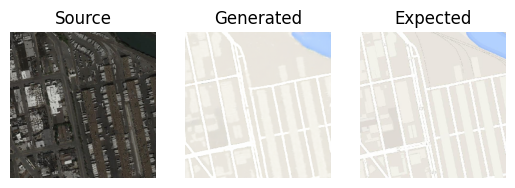

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_064200.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (1, 256, 256, 3)


1/1 [==============================] - 0s 391ms/step


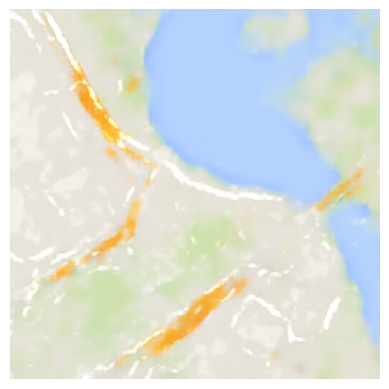

In [ ]:
# example of loading a pix2pix model and using it for one-off image translation
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

# load source image
src_image = load_image('/content/drive/MyDrive/Colab Notebooks/satellite3.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_064200.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_5[0][0]']       
                                                                                            